In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mv '/content/drive/MyDrive/Colab Notebooks/Dataset Exploration Notebook' '/content/drive/MyDrive/Colab Notebooks/Valify'

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'arabic-documents-ocr-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3371421%2F5863463%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240609%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240609T190852Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8125122f0917863d4087dd317b9ebd97e96cf4b07bcaf38c472ccefdf40d565d7885b9087104e4902b84f87c8a25e41db12038ddea19d7b344a27864805cf3201301e0e8dae46cf4a2f0d2975e78a7d853fcc8460f87c5e60201498473c6bd30d66e17bc538853734a6c7f03bf33fc701bc4a9689b3917f55944d305d61c6a4540ce54ec5d0be17c33cfdb8d13a25f145ecea5e9130b88450e7201e12533b955e8b46afc00c7e607c7a731a013fb376c46843925a2e2ccaa10418cec51295b53217ddcc4b60f703b70921ccd73e9dea77148ccaaef918f8c22255643ad0f2f0c65d0a865789f03df362e1c7f43712005acaa2293c2c252e7c93d9c421fa9ffcf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9532503357 bytes downloaded
Downloaded and uncompressed: arabic-documents-ocr-dataset
Data source import complete.


In [ ]:
import torch
device = 'cuda'
print(f'Memory allocated: {torch.cuda.memory_allocated()}')

Memory allocated: 0


# Project meta json to check the overall structure

In [ ]:
import json
from PIL import Image
import matplotlib.pyplot as plt

# Path to JSON file and image file
json_file_path = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/meta.json"

# Load JSON data
with open(json_file_path, "r", encoding="utf-8") as json_file:
    json_data = json.load(json_file)

# Print JSON structure
print("JSON Structure:")
print(json.dumps(json_data, indent=4))

JSON Structure:
{
    "classes": [
        {
            "title": "Body text",
            "shape": "rectangle",
            "color": "#BD2AEA",
            "geometry_config": {},
            "id": 10214732,
            "hotkey": "B"
        },
        {
            "title": "Title",
            "shape": "rectangle",
            "color": "#557AC3",
            "geometry_config": {},
            "id": 10214731,
            "hotkey": "T"
        },
        {
            "title": "Page",
            "shape": "polygon",
            "color": "#BECE6F",
            "geometry_config": {},
            "id": 10214730,
            "hotkey": "P"
        }
    ],
    "tags": [
        {
            "name": "Redacted",
            "value_type": "none",
            "color": "#D4DF53",
            "id": 30308108,
            "hotkey": "R",
            "applicable_type": "imagesOnly",
            "classes": []
        },
        {
            "name": "Transcription",
            "value_type": "any_str

# Reading Images and drawing bounding boxes

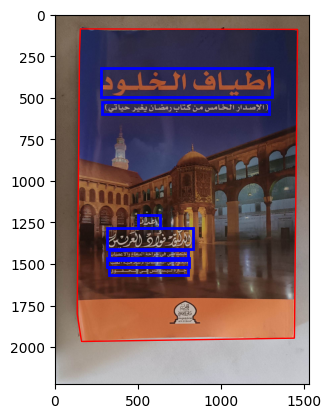

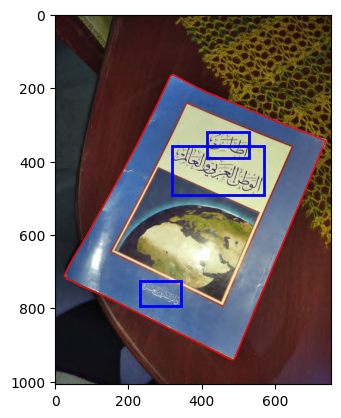

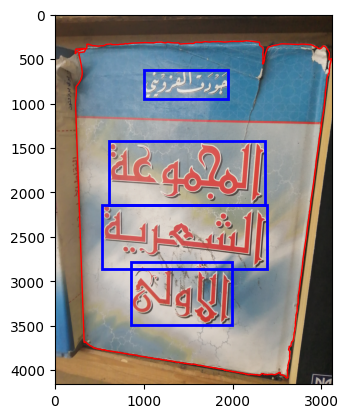

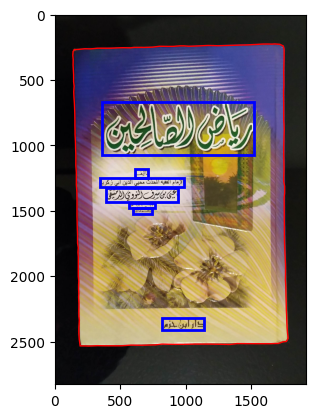

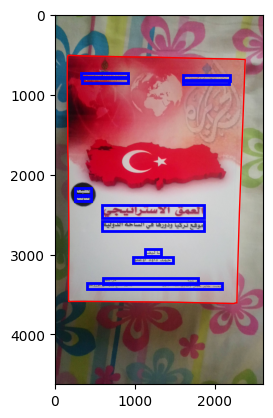

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Folder paths
ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Book/ann"
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Book/img"

# Counter for the number of images displayed
num_images_displayed = 0

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Access objects
        objects = data["objects"]

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image and rotate it to correct orientation if needed
        image = Image.open(img_path)
        if hasattr(image, "_getexif"):  # Check if image has EXIF data (orientation)
            exif = image._getexif()
            if exif:
                orientation = exif.get(274, 1)  # Default orientation is 1 if not found in EXIF data
                rotation_angle = 0

                if orientation == 3:  # Rotate by 180 degrees
                    rotation_angle = 180
                elif orientation == 6:  # Rotate clockwise by 90 degrees
                    rotation_angle = -90
                elif orientation == 8:  # Rotate counterclockwise by 90 degrees
                    rotation_angle = 90

                # Rotate the image if the orientation requires it
                if rotation_angle != 0:
                    image = image.rotate(rotation_angle, expand=True)

        # Create figure and axis
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(image)

        # Define a function to draw polygons based on exterior points
        def draw_polygon(ax, points, color='r'):
            # Create and add the polygon patch to the plot
            polygon = patches.Polygon(points, closed=True, fill=None, edgecolor=color)
            ax.add_patch(polygon)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(ax, points, color='b'):
            # Calculate the coordinates of the top-left corner and the width and height of the rectangle
            x1 = min(points[0][0], points[1][0])
            y1 = min(points[0][1], points[1][1])
            width = abs(points[0][0] - points[1][0])
            height = abs(points[0][1] - points[1][1])

            # Create and add the rectangle patch to the plot
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, fill=None)
            ax.add_patch(rect)

        # Iterate through objects and draw polygons or rectangles based on the geometry type
        for obj in objects:
            exterior_points = obj["points"]["exterior"]
            if obj["geometryType"] == "polygon":
                draw_polygon(ax, exterior_points)
            elif obj["geometryType"] == "rectangle":
                draw_rectangle(ax, exterior_points)

        # Show plot
        plt.show()

        # Increment the counter
        num_images_displayed += 1

        # Check if 5 images have been displayed
        if num_images_displayed >= 5:
            break


# Save Rotated Images

In [ ]:
import os
from PIL import Image

# Folder paths
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Book/img"
output_folder = "/kaggle/ds/images/"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over image files in the input folder
for filename in os.listdir(img_folder):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        # Load the image
        img_path = os.path.join(img_folder, filename)
        image = Image.open(img_path)

        # Rotate the image to correct orientation if needed
        if hasattr(image, "_getexif"):  # Check if image has EXIF data (orientation)
            exif = image._getexif()
            if exif:
                orientation = exif.get(274, 1)  # Default orientation is 1 if not found in EXIF data
                rotation_angle = 0

                if orientation == 3:  # Rotate by 180 degrees
                    rotation_angle = 180
                elif orientation == 6:  # Rotate clockwise by 90 degrees
                    rotation_angle = -90
                elif orientation == 8:  # Rotate counterclockwise by 90 degrees
                    rotation_angle = 90

                # Rotate the image if the orientation requires it
                if rotation_angle != 0:
                    image = image.rotate(rotation_angle, expand=True)

        # Save the rotated image to the output folder with the same filename and extension
        output_path = os.path.join(output_folder, filename)
        image.save(output_path)

print("Rotated images have been saved to the 'images' folder.")

Rotated images have been saved to the 'rotated_images' folder.


# Copy images to new location in drive

In [ ]:
!cp /kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Book/ann /content/drive/MyDrive/DS-OCR --recursive


In [ ]:
!cp /kaggle/ds/images /content/drive/MyDrive/DS-OCR --recursive

# Load Labels/ Classes

# Now time to create Masks

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Folder paths
ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/ann"
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/img"
mask_folder = "/kaggle/working/masks"  # Folder to save mask images

# Create the mask folder if it doesn't exist
os.makedirs(mask_folder, exist_ok=True)

# Initialize counter for the number of images shown
num_images_shown = 0

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image
        image = Image.open(img_path)

        # Create a blank image for drawing
        mask_image = Image.new("L", image.size)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(draw, points):
            # Create and add the rectangle to the mask
            draw.rectangle(points, outline=255, fill=255)

        # Create ImageDraw object
        draw = ImageDraw.Draw(mask_image)

        # Iterate through objects and draw rectangles on the mask
        for obj in data["objects"]:
            if obj["geometryType"] == "rectangle":
                exterior_points = obj["points"]["exterior"]
                draw_rectangle(draw, [(p[0], p[1]) for p in exterior_points])

        # Display the mask image using Matplotlib
        plt.imshow(mask_image, cmap="gray")
        plt.title(f"Mask for {img_filename_base}")
        plt.axis("off")
        plt.show()

        # Increment the counter for the number of images shown
        num_images_shown += 1

        # Check if 10 images have been shown, and break the loop if so
        if num_images_shown >= 10:
            break

# print("Mask images have been saved to the 'masks' folder.")


# Displaying masks next to original image
small hint : the original images might be oriented , don't worry we'll fix it later

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Folder paths
ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/ann"
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/img"
mask_folder = "/kaggle/working/masks2"  # Folder to save mask images

# Create the mask folder if it doesn't exist
os.makedirs(mask_folder, exist_ok=True)

# Initialize counter for the number of images shown
num_images_shown = 0

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image
        image = Image.open(img_path)

        # Create a blank image for drawing
        mask_image = Image.new("L", image.size)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(draw, points):
            # Create and add the rectangle to the mask
            draw.rectangle(points, outline=255, fill=255)

        # Create ImageDraw object
        draw = ImageDraw.Draw(mask_image)

        # Iterate through objects and draw rectangles on the mask
        for obj in data["objects"]:
            if obj["geometryType"] == "rectangle":
                exterior_points = obj["points"]["exterior"]
                draw_rectangle(draw, [(p[0], p[1]) for p in exterior_points])

        # Display the original image and the mask side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display original image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Display mask image
        axes[1].imshow(mask_image, cmap="gray")
        axes[1].set_title("Mask Image")
        axes[1].axis("off")

        plt.show()

        # Increment the counter for the number of images shown
        num_images_shown += 1

        # Check if 10 images have been shown, and break the loop if so
        if num_images_shown >= 10:
            break

# print("Mask images have been saved to the 'masks' folder.")


# showing polygons as frame around segmented text and saving the final masks the i'll use later in my model

In [ ]:
# import os
# import json
# import numpy as np
# from PIL import Image, ImageDraw
# import matplotlib.pyplot as plt

# # Folder paths
# ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/ann"
# img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/img"
# mask_folder = "/kaggle/working/masks"  # Folder to save mask images

# # Create the mask folder if it doesn't exist
# os.makedirs(mask_folder, exist_ok=True)

# # Iterate over JSON files in the 'ann' folder
# for filename in os.listdir(ann_folder):
#     if filename.endswith(".json"):
#         # Load JSON data from the file
#         json_file_path = os.path.join(ann_folder, filename)
#         with open(json_file_path, "r", encoding="utf-8") as json_file:
#             data = json.load(json_file)

#         # Find corresponding image file
#         img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
#         img_extensions = (".jpg", ".jpeg", ".png")
#         img_path = None
#         for ext in img_extensions:
#             img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
#             if os.path.exists(img_candidate_path):
#                 img_path = img_candidate_path
#                 break

#         if img_path is None:
#             print(f"No corresponding image found for {filename}")
#             continue

#         # Load the image
#         image = Image.open(img_path)

#         # Create an empty mask
#         mask = np.zeros_like(np.array(image))

#         # Create a blank image for drawing
#         mask_image = Image.new("L", image.size)

#         # Define a function to draw polygons based on exterior points
#         def draw_polygon(draw, points, line_width=1):
#             # Create and add the polygon outline to the mask
#             draw.line(points + [points[0]], fill=255, width=line_width)

#         # Define a function to draw rectangles based on exterior points
#         def draw_rectangle(draw, points):
#             # Create and add the rectangle to the mask
#             draw.rectangle(points, outline=255, fill=255)

#         # Create ImageDraw object
#         draw = ImageDraw.Draw(mask_image)

#         # Iterate through objects and draw polygons or rectangles on the mask
#         for obj in data["objects"]:
#             exterior_points = obj["points"]["exterior"]
#             if obj["geometryType"] == "polygon":
#                 draw_polygon(draw, [tuple(p) for p in exterior_points], line_width=2)  # Set line width as desired
#             elif obj["geometryType"] == "rectangle":
#                 draw_rectangle(draw, [(p[0], p[1]) for p in exterior_points])

#         # Save the mask image
#         mask_filename = os.path.join(mask_folder, img_filename_base + "_mask.png")
#         mask_image.save(mask_filename)

# #         # Display the image and mask side by side for comparison
# #         fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# #         # Display the original image
# #         axes[0].imshow(image)
# #         axes[0].set_title(f"Original Image: {img_filename_base}")
# #         axes[0].axis("off")

# #         # Display the mask image
# #         axes[1].imshow(mask_image, cmap="gray")
# #         axes[1].set_title(f"Mask for {img_filename_base}")
# #         axes[1].axis("off")

# #         plt.show()

# print("Mask images have been saved to the 'masks' folder.")


# Save only masks without outer shape polygon

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw

# Folder paths
ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/ann"
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/img"
mask_folder = "/kaggle/working/masks"  # Folder to save mask images

# Create the mask folder if it doesn't exist
os.makedirs(mask_folder, exist_ok=True)

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image
        image = Image.open(img_path)

        # Create a blank mask image
        mask_image = Image.new("L", image.size)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(draw, points):
            # Create and add the rectangle to the mask
            draw.rectangle(points, outline=255, fill=255)

        # Create ImageDraw object
        draw = ImageDraw.Draw(mask_image)

        # Iterate through objects and draw rectangles on the mask
        for obj in data["objects"]:
            if obj["geometryType"] == "rectangle":
                exterior_points = obj["points"]["exterior"]
                draw_rectangle(draw, [(p[0], p[1]) for p in exterior_points])

        # Convert mask image pixel values to the range [0, 1]
        mask_image = np.array(mask_image)

        # Save the mask image
        mask_filename = os.path.join(mask_folder, img_filename_base + "_mask.png")
        Image.fromarray((mask_image).astype(np.uint8)).save(mask_filename)

print("Mask images with only rectangles have been saved to the 'masks' folder.")


# let's load one of the mask images and view its pixel range to confirm that it is indeed in the range [0, 255]

In [ ]:
import os
import numpy as np
from PIL import Image

# Select a mask image
mask_folder = "/kaggle/working/masks"
mask_filename = os.listdir(mask_folder)[5]
mask_path = os.path.join(mask_folder, mask_filename)

# Load the mask image
mask_image = Image.open(mask_path)

# Convert to numpy array
mask_array = np.array(mask_image)

# View the pixel range
print("Pixel range of the mask image:", mask_array.min(), "-", mask_array.max())


# lets fix the original images and save them to a directory

In [ ]:
import os
from PIL import Image

# Folder paths
img_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/img"
output_folder = "/kaggle/working/rotated_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over image files in the input folder
for filename in os.listdir(img_folder):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        # Load the image
        img_path = os.path.join(img_folder, filename)
        image = Image.open(img_path)

        # Rotate the image to correct orientation if needed
        if hasattr(image, "_getexif"):  # Check if image has EXIF data (orientation)
            exif = image._getexif()
            if exif:
                orientation = exif.get(274, 1)  # Default orientation is 1 if not found in EXIF data
                rotation_angle = 0

                if orientation == 3:  # Rotate by 180 degrees
                    rotation_angle = 180
                elif orientation == 6:  # Rotate clockwise by 90 degrees
                    rotation_angle = -90
                elif orientation == 8:  # Rotate counterclockwise by 90 degrees
                    rotation_angle = 90

                # Rotate the image if the orientation requires it
                if rotation_angle != 0:
                    image = image.rotate(rotation_angle, expand=True)

        # Save the rotated image to the output folder with the same filename and extension
        output_path = os.path.join(output_folder, filename)
        image.save(output_path)

print("Rotated images have been saved to the 'rotated_images' folder.")


# Now lets view masks and corresponding masks after orientation fixes

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Folder paths
ann_folder = "/kaggle/input/arabic-documents-ocr-dataset/Documents/Documents/Handwritten text/ann"
img_folder = "/kaggle/working/rotated_images"
mask_folder = "/kaggle/working/masks"  # Folder to save mask images

# Create the mask folder if it doesn't exist
os.makedirs(mask_folder, exist_ok=True)

# Initialize counter for the number of images shown
num_images_shown = 0

# Iterate over JSON files in the 'ann' folder
for filename in os.listdir(ann_folder):
    if filename.endswith(".json"):
        # Load JSON data from the file
        json_file_path = os.path.join(ann_folder, filename)
        with open(json_file_path, "r", encoding="utf-8") as json_file:
            data = json.load(json_file)

        # Find corresponding image file
        img_filename_base = os.path.splitext(filename)[0]  # Get filename without extension
        img_extensions = (".jpg", ".jpeg", ".png")
        img_path = None
        for ext in img_extensions:
            img_candidate_path = os.path.join(img_folder, img_filename_base + ext)
            if os.path.exists(img_candidate_path):
                img_path = img_candidate_path
                break

        if img_path is None:
            print(f"No corresponding image found for {filename}")
            continue

        # Load the image
        image = Image.open(img_path)

        # Create a blank image for drawing
        mask_image = Image.new("L", image.size)

        # Define a function to draw polygons based on exterior points
        def draw_polygon(draw, points, line_width=1):
            # Create and add the polygon outline to the mask
            draw.line(points + [points[0]], fill=255, width=line_width)

        # Define a function to draw rectangles based on exterior points
        def draw_rectangle(draw, points):
            # Create and add the rectangle to the mask
            draw.rectangle(points, outline=255, fill=255)

        # Create ImageDraw object
        draw = ImageDraw.Draw(mask_image)

        # Iterate through objects and draw polygons or rectangles on the mask
        for obj in data["objects"]:
            exterior_points = obj["points"]["exterior"]
            if obj["geometryType"] == "polygon":
                draw_polygon(draw, [tuple(p) for p in exterior_points], line_width=2)  # Set line width as desired
            elif obj["geometryType"] == "rectangle":
                draw_rectangle(draw, [(p[0], p[1]) for p in exterior_points])

        # Display the image and mask side by side for comparison
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the original image
        axes[0].imshow(image)
        axes[0].set_title(f"Original Image: {img_filename_base}")
        axes[0].axis("off")

        # Display the mask image
        axes[1].imshow(mask_image, cmap="gray")
        axes[1].set_title(f"Mask for {img_filename_base}")
        axes[1].axis("off")

        plt.show()

        # Increment the counter for the number of images shown
        num_images_shown += 1

        # Check if 10 images have been shown, and break the loop if so
        if num_images_shown >= 10:
            break

print("Mask images have been saved to the 'masks' folder.")


# Dataset Class to return image and corresponding mask

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, img_folder, mask_folder, transform=None, target_size=(256, 256)):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.target_size = target_size

        self.img_filenames = sorted([filename for filename in os.listdir(img_folder) if filename.endswith((".jpg", ".jpeg", ".png"))])
        self.mask_filenames = sorted([filename for filename in os.listdir(mask_folder) if filename.endswith(".png")])

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        mask_filename = img_filename.split('.')[0] + '_mask.png'

        img_path = os.path.join(self.img_folder, img_filename)
        mask_path = os.path.join(self.mask_folder, mask_filename)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load mask
        mask = Image.open(mask_path)

        # Resize image and mask
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations for images and masks
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Example usage:
dataset = CustomDataset(img_folder="/kaggle/working/rotated_images",
                        mask_folder="/kaggle/working/masks",
                       transform=transform,
                       target_size=(224, 224))
image, mask = dataset[1]
print(image.size, mask.size)


In [ ]:
import matplotlib.pyplot as plt

# Convert image and mask to numpy arrays
image_np = np.array(image.permute(1,2,0))
mask_np = np.array(mask.permute(1,2,0))

# Display image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()


# DataLoader Configs

In [ ]:
# Initialize the dataset
# dataset = CustomDataset(img_folder="/kaggle/working/rotated_images", mask_folder="/kaggle/working/masks", transform=transform)
from torch.utils.data import Dataset, DataLoader, random_split  # Import random_split

# Split dataset into train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

train_set, val_set, test_set = random_split(dataset, [num_train, num_val, num_test])

# Initialize data loaders for train, validation, and test sets
batch_size = 8  # Set your desired batch size
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [ ]:
g ,h = next(iter(train_loader))
g.shape , h.shape

# Double Check everything

In [ ]:
g[0].shape , h[0].shape

# Convert image and mask to numpy arrays
image_np = np.array(g[1].permute(1,2,0))
mask_np = np.array(h[1].permute(1,2,0))

# Display image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_np)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming you have a data loader named 'dataloader'
# Make sure you have already loaded your CustomImageMaskDataset

# Define inverse transforms to convert tensors back to PIL images
inv_transform = transforms.Compose([
    transforms.ToPILImage(),
])

# Iterate through the data loader
for batch in train_loader:
    images, masks = batch

    # Visualize the first image and its mask
    image_to_show = inv_transform(images[0].cpu())
    mask_to_show = inv_transform(masks[0].cpu())

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_to_show)
    plt.title('Original Image')

    # Plot the corresponding mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_to_show, cmap='gray')  # Assuming binary masks
    plt.title('Corresponding Mask')

    # Plot the pixel value distribution in the mask
    plt.subplot(1, 3, 3)
    mask_values = masks[0].view(-1).numpy()
    plt.hist(mask_values, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='blue', alpha=0.7)
    plt.xticks([0, 1], ['Background', 'Foreground'])
    plt.title('Distribution of Mask Pixel Values')

    plt.show()

    break  # Break after the first batch to avoid plotting multiple images


In [ ]:
import torch
device = 'cuda'
print(f'Memory allocated: {torch.cuda.memory_allocated()}')

In [ ]:
torch.cuda.memory_allocated()

# Now we're Good togo and do the model building

In [ ]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

# Getting unet pretrained models

In [ ]:
# %%capture
!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

# Define Model
# model = smp.Unet(classes = 1)
model = smp.Unet(encoder_name = "timm-efficientnet-b8",
             encoder_weights = "imagenet",
             in_channels = 3,
             classes = 1)

In [ ]:
import torchinfo
torchinfo.summary(model = model,
        col_width = 17,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

In [ ]:
# We freeze the encoder layer.
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
torchinfo.summary(model = model,
        col_width = 17,
        input_size = [1,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        row_settings = ['var_names'])

In [ ]:
from segmentation_models_pytorch.metrics import get_stats, iou_score

loss_fn = smp.losses.DiceLoss(mode = 'binary', from_logits = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

In [ ]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)

        elif val_loss >= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


In [ ]:
# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, delta = 0.)

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_iou = 0.

    for batch, (X,y) in enumerate(tqdm(dataloader)):
        X = X.to(device, dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        logit_mask = model(X)
        loss = loss_fn(logit_mask, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        prob_mask = logit_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp,fp,fn,tn = get_stats(output = pred_mask.detach().cpu().long(),
                                target = y.cpu().long(),
                                mode = "binary")

        train_iou += iou_score(tp, fp, fn, tn, reduction = "micro").numpy()

    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)

    return train_loss, train_iou

In [ ]:
def val_step(model:torch.nn.Module,
             dataloader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module):

    model.eval()

    val_loss = 0.
    val_iou = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(tqdm(dataloader)):
            X = X.to(device, dtype = torch.float32)
            y = y.to(device, dtype = torch.float32)
            logit_mask = model(X)
            loss = loss_fn(logit_mask, y)
            val_loss += loss.item()

            prob_mask = logit_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()

            tp, fp, fn, tn = get_stats(output = pred_mask.detach().cpu().long(),
                                       target = y.cpu().long(),
                                       mode = "binary")

            val_iou += iou_score(tp, fp, fn, tn, reduction = "micro").numpy()

    val_loss = val_loss / len(dataloader)
    val_iou = val_iou / len(dataloader)

    return val_loss, val_iou



In [ ]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):

    results = {'train_loss':[], 'train_iou':[], 'val_loss':[], 'val_iou':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_iou = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        val_loss, val_iou = val_step(model = model,
                                     dataloader = val_dataloader,
                                     loss_fn = loss_fn)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train IOU: {train_iou:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ',
              f'Val IOU: {val_iou:.4f}')

        early_stopping(val_loss, model)

        if early_stopping.early_stop == True:
            print("Early Stopping!!!")
            break

        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results

In [ ]:
# Training!!!
SEED = 42
EPOCHS = 100
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device),
                train_loader,
                val_loader,
                loss_fn,
                optimizer,
                early_stopping,
                EPOCHS)

In [ ]:
def loss_and_metric_plot(results:dict):
    plt.style.use("ggplot")

    training_loss = results['train_loss']
    training_metric = results['train_iou']
    valid_loss = results['val_loss']
    valid_metric = results['val_iou']

    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
    ax = ax.flat

    ax[0].plot(training_loss, color = "red", label = 'Train')
    ax[0].plot(valid_loss, color = "blue", label = 'Valid')
    ax[0].set_ylabel("Loss", fontsize = 8, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 8, fontweight = "bold", color = "black")
    ax[0].set_title("DiceLoss", fontsize = 11, fontweight = "bold", color = "black")

    ax[1].plot(training_metric, color = "red", label = 'Train')
    ax[1].plot(valid_metric, color = "blue", label = 'Valid')
    ax[1].set_ylabel("Score", fontsize = 8, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 8, fontweight = "bold", color = "black")
    ax[1].set_title("IOU", fontsize = 11, fontweight = "bold", color = "black")

    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    fig.show()

In [ ]:
loss_and_metric_plot(RESULTS)

# Predictions

In [ ]:
def predictions(test_dataloader:torch.utils.data.DataLoader):

    loaded_model = smp.Unet(encoder_name = "timm-efficientnet-b8",
                        encoder_weights = None,
                        in_channels = 3,
                        classes = 1)

    checkpoint = torch.load("/kaggle/working/best_model.pth")

    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device)

    loaded_model.eval()

    pred_mask_test = []

    with torch.inference_mode():
        for X,_ in tqdm(test_loader):
            X = X.to(device, dtype = torch.float)
            logit_mask = loaded_model(X)
            prob_mask = logit_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test

In [ ]:
pred_mask_test = predictions(test_loader)

In [ ]:
# We are going to create our tensors so we can plot later.
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_loader:
  IMAGE_TEST.append(img)
  MASK_TEST.append(mask)

IMAGES_TEST = torch.cat(IMAGE_TEST)

MASKS_TEST = torch.cat(MASK_TEST)

In [ ]:
TP, FP, FN, TN = get_stats(pred_mask_test.long(),
                           (MASKS_TEST>0.5).float().long(),
                           mode = "binary")

# Final Metric -- 54 % IOU

In [ ]:
iou_test = iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

In [ ]:
# We visualize each prediction and its respective original mask.
fig, ax = plt.subplots(nrows = 44, ncols = 2, figsize = (30, 120))

for i,(j,k) in enumerate(zip(MASKS_TEST, pred_mask_test)):

    if i>43:
        break

    ax[i,0].imshow(j.squeeze().numpy(), alpha = 0.8)
    ax[i,0].set_title("Original", fontsize = 10, fontweight = "bold")
    ax[i,0].axis('off')

    ax[i,1].imshow(k.squeeze().numpy(), alpha = 0.8)
    ax[i,1].set_title("Predicted", fontsize = 10, fontweight = "bold")
    ax[i,1].axis('off')


fig.tight_layout()
fig.show()